In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.makers import ReflectedRegionsFinder
from gammapy.maps import MapAxis, WcsGeom

In [8]:
offset = 0.4
src_RA = 300.3
src_DEC = -28.
pnt_RA = src_RA + offset
pnt_DEC = src_DEC

On_size = 0.2
Exclusion_size = 0.35


pointing = SkyCoord(pnt_RA, pnt_DEC, unit='deg', frame='icrs')
target_position = SkyCoord(src_RA, src_DEC, unit='deg', frame='icrs')
On_size_angle = Angle(On_size, 'deg')
Exclusion_size_angle = Angle(Exclusion_size, 'deg')

exclusion_mask = CircleSkyRegion(target_position, Exclusion_size_angle)
on_region = CircleSkyRegion(target_position, On_size_angle)

geom = WcsGeom.create(skydir=target_position, npix=(200, 200), binsz=0.02, frame="icrs")
geom_image = geom.to_image()
exclusion_mask = ~geom_image.region_mask([exclusion_mask])

finder = ReflectedRegionsFinder(region=on_region, center=pointing, exclusion_mask=exclusion_mask)

Regions = finder.run()

OFF_region_radius_pos = []
for i in range(len(Regions)):
    OFF_region_radius_pos.append(Regions[i].center.separation(target_position).deg)
    
print("OFF region distance of source : ", OFF_region_radius_pos)

OFF region distance of source :  [0.57339878112407, 0.7061108151293467, 0.5944023798726865]


In [9]:
def pollution(PSF_68_containment):
    Nevents = 1000000
    width = PSF_68_containment/1.51
    
    mean = [0, 0]
    cov = [[width**2, 0], [0, width**2]]
    
    events = np.random.multivariate_normal((0,0), cov, Nevents)
    
    #plt.scatter(events[:,0],events[:,1])
    
    OFF_event = len(OFF_region_radius_pos)*[0]
    ON_event = 0
    Containment_event = 0
    OFF_event_pollution = 0
    
    for i in range(Nevents):
        if (np.sqrt((events[:,0][i])**2 + events[:,1][i]**2) < width*1.51):
            Containment_event += 1
        if (np.sqrt((events[:,0][i])**2 + events[:,1][i]**2) < On_size):
            ON_event += 1
        for j in range(len(OFF_region_radius_pos)):
            if (np.sqrt((events[:,0][i]-OFF_region_radius_pos[j])**2 + events[:,1][i]**2) < On_size):
                OFF_event[j] += 1
        OFF_event_pollution = np.sum(OFF_event)/len(OFF_event)
            
            
            
    print("The level of pollution is ", 100*OFF_event_pollution/ON_event, "%")
    return OFF_event_pollution/ON_event

In [4]:
PSF = [0.1,0.2,0.3,0.4,0.5,0.8,1.]
poll = []
for i in range(len(PSF)):
    poll.append(pollution(PSF[i]))

The level of pollution is  0.0 %
The level of pollution is  0.10567033793932554 %
The level of pollution is  2.3596059608979583 %
The level of pollution is  9.49292111912071 %
The level of pollution is  20.312127065119068 %
The level of pollution is  51.52926721907001 %
The level of pollution is  64.84021334767604 %


Text(0, 0.5, 'pollution ratio')

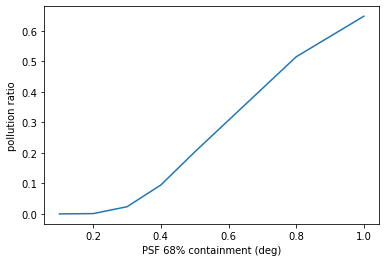

In [5]:
plt.plot(PSF,poll)
plt.xlabel("PSF 68% containment (deg)")
plt.ylabel("pollution ratio")
#plt.yscale("log")